# Kinetic Eye

# Warehouse Risk Model Analysis

## Problem Prompt: 

We are looking to build a warehouse risk model, but we don’t have a lot of accidents or injuries to refer to yet. One thought is that distance travelled by workers and vehicles is a potential predictor of risk. Let’s assume that our safety events serve as a good proxy for safety outcomes. How well does distance travelled predict risk? What would you have to do to know for sure?

### Initial Analysis:

In the process of building a warehouse risk model, we must first determine how risk is measured. For this problem, we will assume our predicted labeled will be binary (0 or 1), where 1 indicates an accident or injury occurred for a given trip. Once we collected labeled data, we will be able to use logistic regression to predict risk.

As stated in the problem, we will be using a distanced-based metric to model risk. Inituitively, greater distances travelled will increase exposure to risk. However, there is the exception where we may find high exposure with small distance travelled, such as the turning around corners. To better model risk in this aspect, we would need to collect more data such as geospatial features. For the sake of this problem, we will solely follow our inituition.

This notebook will explore and analyze distanced travelled to understand how well the feature will predict risk. This notebook will also explore other methods and useful features to predict risk.

### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
from scipy import stats

### Importing csv data files as pandas dataframe

In [2]:
odometry = pd.read_csv("odometry.csv")
events = pd.read_csv("events.csv")

In [3]:
odometry.head()

,_id,camera_id,video_name,class_name,traveled_distance,start_timestamp,end_timestamp,local_start_timestamp
0,"ObjectId(""5ecb9dc250efdb0008054f36"")",5,040234-040603.mp4,Forklift,9.880006,2020-05-25T09:05:10.000Z,2020-05-25T09:19:54.000Z,2020-05-25T04:05:10.000Z
1,"ObjectId(""5ecb9dc250efdb0008054f37"")",5,040234-040603.mp4,Person,6.088650,2020-05-25T09:06:22.000Z,2020-05-25T09:19:14.000Z,2020-05-25T04:06:22.000Z
2,"ObjectId(""5ecb9dc250efdb0008054f38"")",5,040234-040603.mp4,Person,18.249779,2020-05-25T09:36:46.000Z,2020-05-25T09:50:58.000Z,2020-05-25T04:36:46.000Z
3,"ObjectId(""5ecb9dc250efdb0008054f39"")",5,040234-040603.mp4,Person,8.291737,2020-05-25T09:59:38.000Z,2020-05-25T10:05:42.000Z,2020-05-25T04:59:38.000Z
4,"ObjectId(""5ecb9dc250efdb0008054f3a"")",5,040234-040603.mp4,Forklift,8.895892,2020-05-25T10:02:06.000Z,2020-05-25T10:05:22.000Z,2020-05-25T05:02:06.000Z


In [4]:
events.head()

,Unnamed: 0,Date,Hour,Min,Event Type,Unnamed: 5
0,NaN,2020-05-24,22.0,28,SocialDistancing,NaN
1,NaN,2020-05-24,21.0,43,SocialDistancing,NaN
2,NaN,2020-05-24,20.0,27,SocialDistancing,NaN
3,NaN,2020-05-24,19.0,9,SocialDistancing,NaN
4,NaN,2020-05-25,11.0,2,FaceMask,NaN


## Exploratory Data Analysis

### Data Cleaning

In [5]:
# checking for empty or null values
print("Any null values in odometry?:", odometry.isnull().values.any())
print("Any null values in events?:", events.isnull().values.any())

Any null values in odometry?: False
Any null values in events?: True


In [6]:
# removing null columns
events = events.drop(['Unnamed: 0', 'Unnamed: 5'], axis=1)
print("Unique event types: ", np.unique(events['Event Type'].values))
print("The date column type is: ", type(events['Date'].values[0]))
print("Any null values in events?:", events.isnull().values.any())

Unique event types:  ['Driver entering' 'FaceMask' 'Gloves' 'Handcart Riding' 'Other damage'
 'SocialDistancing' 'Speeding' 'Vests']
The date column type is:  <class 'str'>
Any null values in events?: False


In [7]:
# checking columns types
print("The timestamp columns type is: ", type(odometry['start_timestamp'].values[0]))
print("The traveled_distance column type is: ", type(odometry['traveled_distance'].values[0]))

The timestamp columns type is:  <class 'str'>
The traveled_distance column type is:  <class 'numpy.float64'>


In [8]:
# converting timestamp columns from str to datetime
odometry['start_timestamp'] = [datetime.strptime(time, "%Y-%m-%dT%H:%M:%S.%fZ") for time in odometry['start_timestamp'].values]
odometry['end_timestamp'] = [datetime.strptime(time, "%Y-%m-%dT%H:%M:%S.%fZ") for time in odometry['end_timestamp'].values]
odometry['local_start_timestamp'] = [datetime.strptime(time, "%Y-%m-%dT%H:%M:%S.%fZ") for time in odometry['local_start_timestamp'].values]

In [9]:
events.head()

,Date,Hour,Min,Event Type
0,2020-05-24,22.0,28,SocialDistancing
1,2020-05-24,21.0,43,SocialDistancing
2,2020-05-24,20.0,27,SocialDistancing
3,2020-05-24,19.0,9,SocialDistancing
4,2020-05-25,11.0,2,FaceMask


In [10]:
# converting timestamp columns from str to datetime
events['Date'] = [datetime.strptime(date, "%Y-%m-%d") for date in events['Date'].values]

### Feature Engineering

In [11]:
time_delta = odometry['end_timestamp'].values - odometry['start_timestamp'].values
odometry['trip_duration'] = [(delta / np.timedelta64(1, 's')) for delta in time_delta]
# trip duration measured in seconds

In [12]:
odometry['avg_velocity'] = odometry['traveled_distance'].values / odometry['trip_duration']
# average velocity measured in meters per second

In [13]:
odometry.head()

,_id,camera_id,video_name,class_name,traveled_distance,start_timestamp,end_timestamp,local_start_timestamp,trip_duration,avg_velocity
0,"ObjectId(""5ecb9dc250efdb0008054f36"")",5,040234-040603.mp4,Forklift,9.880006,2020-05-25 09:05:10,2020-05-25 09:19:54,2020-05-25 04:05:10,884.0,0.011176
1,"ObjectId(""5ecb9dc250efdb0008054f37"")",5,040234-040603.mp4,Person,6.088650,2020-05-25 09:06:22,2020-05-25 09:19:14,2020-05-25 04:06:22,772.0,0.007887
2,"ObjectId(""5ecb9dc250efdb0008054f38"")",5,040234-040603.mp4,Person,18.249779,2020-05-25 09:36:46,2020-05-25 09:50:58,2020-05-25 04:36:46,852.0,0.021420
3,"ObjectId(""5ecb9dc250efdb0008054f39"")",5,040234-040603.mp4,Person,8.291737,2020-05-25 09:59:38,2020-05-25 10:05:42,2020-05-25 04:59:38,364.0,0.022779
4,"ObjectId(""5ecb9dc250efdb0008054f3a"")",5,040234-040603.mp4,Forklift,8.895892,2020-05-25 10:02:06,2020-05-25 10:05:22,2020-05-25 05:02:06,196.0,0.045387


In [14]:
events['Year'] = events['Date'].dt.year
events['Month'] = events['Date'].dt.month
events['Day'] = events['Date'].dt.day

In [15]:
events.head()

,Date,Hour,Min,Event Type,Year,Month,Day
0,2020-05-24,22.0,28,SocialDistancing,2020,5,24
1,2020-05-24,21.0,43,SocialDistancing,2020,5,24
2,2020-05-24,20.0,27,SocialDistancing,2020,5,24
3,2020-05-24,19.0,9,SocialDistancing,2020,5,24
4,2020-05-25,11.0,2,FaceMask,2020,5,25


## Data Visualization

### Distance Travelled

/Users/brianle/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Mean of Distance Travelled: 10.59894996265512
Standard Deviation of Distance Travelled: 10.818188997711168


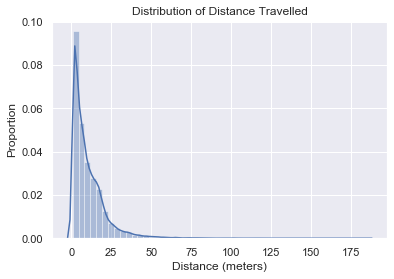

In [16]:
dist = odometry['traveled_distance'].values

sns.set(); np.random.seed(0)
ax = sns.distplot(dist)
ax.set_title('Distribution of Distance Travelled')
ax.set_xlabel("Distance (meters)")
ax.set_ylabel('Proportion')

print("Mean of Distance Travelled:", np.mean(dist))
print("Standard Deviation of Distance Travelled:", np.std(dist))

Text(0.5, 0, 'Distance (meters)')

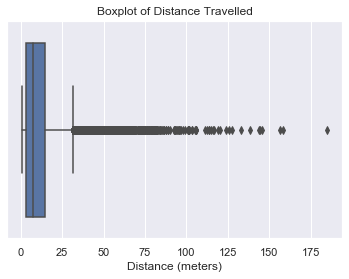

In [17]:
ax = sns.boxplot(dist)
ax.set_title('Boxplot of Distance Travelled')
ax.set_xlabel("Distance (meters)")

### Log Transformation

/Users/brianle/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Standard Deviation of Log Distance Travelled: 0.9629871196538377


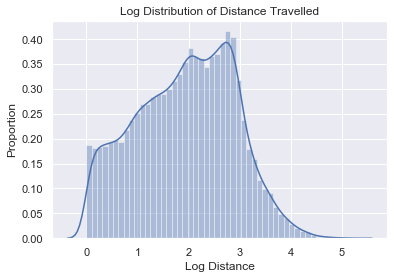

In [18]:
dist_log = np.log(dist)

ax = sns.distplot(dist_log)
ax.set_title('Log Distribution of Distance Travelled')
ax.set_xlabel("Log Distance")
ax.set_ylabel('Proportion')

print("Standard Deviation of Log Distance Travelled:", np.std(dist_log))

### Removing Outliers

Number of trips: 40559
Number of trips after removing outliers: 39801
Proportion of trips left: 0.981311176311053


Text(0, 0.5, 'Proportion')

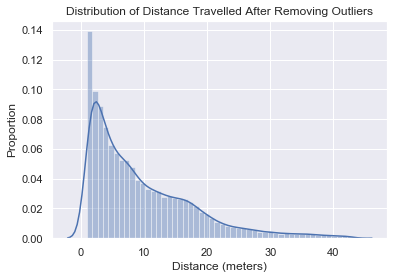

In [19]:
dist_df = odometry['traveled_distance']
print("Number of trips:", len(dist_df))
dist_rmv_outliers = dist_df[(stats.zscore(dist_df)) < 3]
print("Number of trips after removing outliers:", len(dist_rmv_outliers))
print("Proportion of trips left:", len(dist_rmv_outliers) / len(dist_df))

ax = sns.distplot(dist_rmv_outliers.values)
ax.set_title('Distribution of Distance Travelled After Removing Outliers')
ax.set_xlabel("Distance (meters)")
ax.set_ylabel('Proportion')

### Distance Travelled Analysis

In the first distribution plot, we find the data to be significantly right-skewed. Additionally, the boxplot shows a large number of outliers. In a regression model, skewed-data and outliers will have an adverse effect on model performance. To increase model performance, we must reduce the effect of outliers and skewness. Two ways of doing so is to either log transform the values or remove the outliers. After transforming the data or removing outliers, we find the distribution to be much more suitable for our model because there is less variablity. One thing to note is that removing outliers is not always the best method because we lose data, but in our case, we only lost about 2% of our data, so it's reasonable to move forward with this method.

### Distance Travelled by Class

Text(0.5, 1.0, 'Barplot of Travelled Distance by Class')

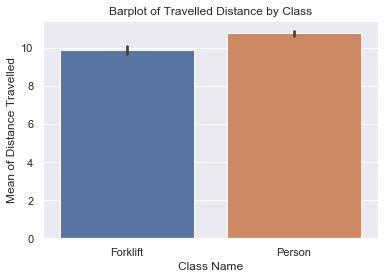

In [20]:
ax = sns.barplot(x = 'class_name', y = 'traveled_distance', data = odometry)
ax.set_xlabel('Class Name')
ax.set_ylabel('Mean of Distance Travelled')
ax.set_title('Barplot of Travelled Distance by Class')

Summary Statistics
Person
Mean of Distance Travelled: 10.76136915048504
Standard Deviation of Distance Travelled: 11.035777994655664
Proportion of Trips: 0.8149855765674696
Forklift
Mean of Distance Travelled: 9.883496037586086
Standard Deviation of Distance Travelled: 9.770293313052868
Proportion of Trips: 0.18501442343253038


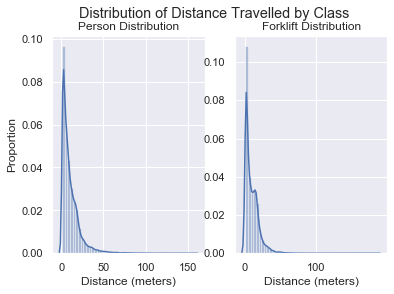

In [21]:
dist_person = odometry[odometry['class_name'] == 'Person']['traveled_distance'].values
dist_fork = odometry[odometry['class_name'] == 'Forklift']['traveled_distance'].values

ax1 = plt.subplot(1, 2, 1)
ax1 = sns.distplot(dist_person)
ax1.set_xlabel('Distance (meters)')
ax1.set_ylabel('Proportion')
ax1.set_title('Person Distribution')

ax2 = plt.subplot(1, 2, 2)
ax2 = sns.distplot(dist_fork)
ax2.set_xlabel('Distance (meters)')
ax2.set_title('Forklift Distribution')

plt.suptitle('Distribution of Distance Travelled by Class')

print("Summary Statistics")
print('================================================')
print('Person')
print("Mean of Distance Travelled:", np.mean(dist_person))
print("Standard Deviation of Distance Travelled:", np.std(dist_person))
print("Proportion of Trips:", len(dist_person) / len(dist))
print('================================================')
print('Forklift')
print("Mean of Distance Travelled:", np.mean(dist_fork))
print("Standard Deviation of Distance Travelled:", np.std(dist_fork))
print("Proportion of Trips:", len(dist_fork) / len(dist))

### Distance Travelled by Class Analysis

Since the data shows two classes of travel mode, forklift and person, I took a closer look at the distribution of distance travelled separated by class. Both classes follow similar distributions and summary statistics. However, the proportion of number of trips by person is 80% while the proportion of number of trips by forklift is 20%. This will introduce biases if we choose not to separate them for our model.

## Additional Analysis

In [22]:
events.head()

,Date,Hour,Min,Event Type,Year,Month,Day
0,2020-05-24,22.0,28,SocialDistancing,2020,5,24
1,2020-05-24,21.0,43,SocialDistancing,2020,5,24
2,2020-05-24,20.0,27,SocialDistancing,2020,5,24
3,2020-05-24,19.0,9,SocialDistancing,2020,5,24
4,2020-05-25,11.0,2,FaceMask,2020,5,25


Text(0.5, 1.0, 'Violin Plot of Event Types across Hours of the Day')

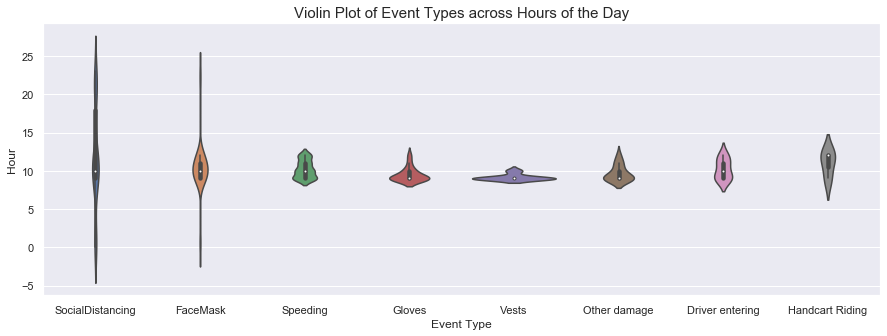

In [23]:
ax = plt.figure(figsize=(15,5))
ax = sns.violinplot(x = "Event Type", y = "Hour", data = events)
ax.set_title('Violin Plot of Event Types across Hours of the Day', fontsize = 15)

From the violin plot, we can visualize the spread of the event types across the day. We can see that COVID-19 regulations are met throughout the entire day. However, based off the other event types, it seems that data is only collected during a short period of time, which is centered at about 10am. 

The event type column may also be a useful feature to predict risk. Events like speeding, other damage, and driver enter could be good indicators of risk. If we could merge this with the odometry dataset, we could improve our model. Currently, the two datasets cannot be merged because they don't share a common feature. 

### Average Velocity

Mean Average Velocity is: 0.012247467749017547 m/s


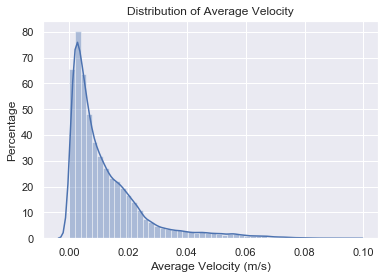

In [24]:
avg_vel = odometry['avg_velocity'].values

ax1 = sns.distplot(avg_vel)
ax1.set_xlabel('Average Velocity (m/s)')
ax1.set_ylabel('Percentage')
ax1.set_title('Distribution of Average Velocity')

print('Mean Average Velocity is:', np.mean(avg_vel), "m/s")


Text(0.5, 1.0, 'Scatterplot of Distance Travelled vs. Average Velocity')

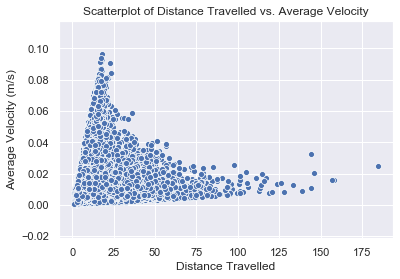

In [25]:
ax = sns.scatterplot(dist, avg_vel)
ax.set_xlabel('Distance Travelled')
ax.set_ylabel('Average Velocity (m/s)')
ax.set_title('Scatterplot of Distance Travelled vs. Average Velocity')

#### Average Velocity by Class

Text(0.5, 1.0, 'Mean Average Velocity by Class')

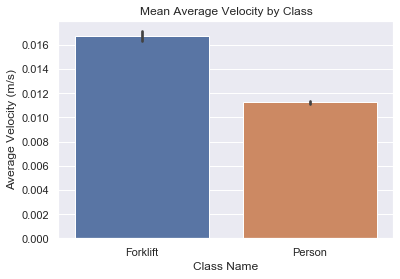

In [26]:
ax = sns.barplot(x = 'class_name', y = 'avg_velocity', data = odometry)
ax.set_xlabel('Class Name')
ax.set_ylabel('Average Velocity (m/s)')
ax.set_title('Mean Average Velocity by Class')

### Average Velocity Analysis

Using distance travelled and start/end timestamps, I feature engineered trip duration in seconds and average velocity in meters per second. In comparing distance travelled and average velocity from the scatterplot, we can see that smaller distances travelled outputs higher average velocity. Inituitively, greater velocity speeds increases exposure to risk, so this could be an predictor for risk as well. This is important to consider in determining if distance travelled is a good indicator. From the barplot, we can see that forklifts generally travel at a significantly higher average velocity than by person. 

# Conclusion

After performing exploratory data analysis and applying intuition, we can conclude that using a distance-based metric is a good feature in modeling warehouse risk. However, to ensure that it will perform well, we must transform the data, either by removing outliers or log transforming the values. This is because the data is strongly right-skewed with a significant amount of outliers, which will have an adverse effect on model performance. 

After training our model, we will use a confusion matrix to calculate model performance metrics such as accuracy, precison, and recall to quantify how well our feature performs. 

In addition, we must also consider the different travel modes in the dataset, person and forklift, because the two modes have different characteristics. I would recommend separating the modes by building separate models because there will be biases otherwise. Using distance travelled and the trip duration, we can feature engineer average velocity, which could also be a good indicator of risk.

# Next Steps

Our next steps would be to collect more data with new features and label our data if possible.